In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [8]:
data = pd.read_csv('./table.csv')

In [9]:
set(data['t1']), set(data['t2'])

({50, 150, 350, 400, 500, 600, 700}, {150, 250, 450, 500, 600, 700, 800})

In [125]:
line_set=data.loc[data.query('t1==150 & t2==800').index]
line_set

,t1,t2,count,dist,ang
31013,150,800,49,497,0.052360
31014,150,800,49,504,0.069813
31015,150,800,49,125,0.034907
31016,150,800,49,245,1.535890
31017,150,800,49,564,1.710420
31018,150,800,49,120,0.017453
31019,150,800,49,111,0.000000
31020,150,800,49,242,1.553340
31021,150,800,49,570,1.692970
31022,150,800,49,-96,3.106690


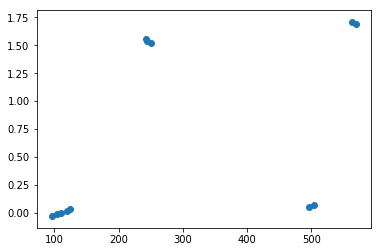

In [156]:
line_set=data.loc[data.query('t1==150 & t2==800').index].copy()

def normalize_lineset(line_set):
    for index in line_set['ang'].index:
        if line_set['ang'][index] > 3:
            line_set.loc[index, 'ang'] -= 3.14
            line_set.loc[index, 'dist'] = -line_set.loc[index, 'dist']

normalize_lineset(line_set)

plt.scatter(line_set.dist, line_set.ang)

In [146]:
def get_data(t1, t2):
    return data.loc[data.query('t1==%s & t2==%s' % (t1, t2)).index]

def normalize_data(line_set):
    normalize_lineset(line_set)
    df=line_set[['dist', 'ang']]
    return pd.DataFrame({'dist': 3.14 * df['dist'] / max(df['dist']), 'ang':df['ang']})

df=normalize_data(get_data(500,500))
df

,dist,ang
32159,2.737860,0.052360
32160,2.776421,0.069813
32161,3.106947,1.710420
32162,1.349649,1.535890
32163,0.688596,0.034907
32164,3.140000,1.692970
32165,1.333123,1.553340
32166,0.655544,0.017453


[[2.75714035 0.06108655]
 [0.67207018 0.02617995]
 [3.12347368 1.701695  ]
 [1.34138596 1.544615  ]]
0.9788953055585196
6752.954618815173
0.021257167559710157


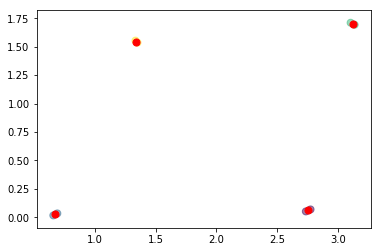

In [117]:
kmeans = KMeans(n_clusters=4).fit(df)
#aggclu = AgglomerativeClustering(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)
plt.scatter(df['dist'], df['ang'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
labels = kmeans.labels_
print(metrics.silhouette_score(df, labels, metric='euclidean'))
print(metrics.calinski_harabasz_score(df, labels))
print(metrics.davies_bouldin_score(df, labels))

In [54]:
good=[(150,800), (350,800), (400,800), (500,500),
      (500,600), (500,700), (500,800), (50,800),
      (600,500), (600,600), (700,450), (700,500)]

In [58]:
def clustering_goodness(clustering):
    return [
        df[kmeans.labels_==i].var().sum()
        for i in set(clustering.labels_)
    ]
clustering_goodness(kmeans)

[0.00028881080678670734,
 0.0008957997607281586,
 0.1428170635912929,
 0.0773909332150303]

In [120]:
#cluster_variations=
#data_variation
#max(cluster_variation)
#min(cluster_distance)
#max(cluster_variation)/min(cluster_distance)
def nanto(x, v):
    if np.isnan(x):
        return v
    return x

def goodness_metric(clustering):
    dv=df.var(axis=0).mean()
    cv=[nanto(df[clustering.labels_==i].var(axis=0).mean(), 0) for i in set(clustering.labels_)]

    def dist(i,j):
        cv_i=df[clustering.labels_==i].mean()
        cv_j=df[clustering.labels_==j].mean()
        d=cv_i-cv_j
        return sum(d*d)
    
    distances=[(i,j,dist(i,j)) for i in set(clustering.labels_) for j in set(clustering.labels_) if i!=j]
    min_cluster_distance = min([distance[2] for distance in distances])
    return max(cv) / min_cluster_distance

In [108]:
np.isnan(pd.DataFrame([1]).var())

0    True
dtype: bool

In [157]:
res = []
for t1 in set(data['t1']):
    for t2 in set(data['t2']):
        df = normalize_data(get_data(t1, t2))
        if df.shape[0] < 4:
            continue
        kmeans = KMeans(n_clusters=4).fit(df)
        labels = kmeans.labels_
        #goodness = metrics.silhouette_score(df, labels, metric='euclidean')
        #goodness = metrics.calinski_harabasz_score(df, labels)
        #goodness = metrics.davies_bouldin_score(df, labels)
        goodness = goodness_metric(kmeans)
        #goodness = clustering_goodness(kmeans)
        res += [(t1, t2, goodness, (t1,t2) in good)]

(array([13.,  1.,  1.,  0.,  3.,  1.,  0.,  0.,  4.,  4.,  3.,  0.,  0.,
         0.,  1.,  0.,  1.,  3.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  3.,
         1.,  1.,  2.,  1.]),
 array([1.62658056e-04, 7.70578556e-03, 1.52489131e-02, 2.27920406e-02,
        3.03351681e-02, 3.78782956e-02, 4.54214231e-02, 5.29645506e-02,
        6.05076781e-02, 6.80508056e-02, 7.55939331e-02, 8.31370606e-02,
        9.06801881e-02, 9.82233156e-02, 1.05766443e-01, 1.13309571e-01,
        1.20852698e-01, 1.28395826e-01, 1.35938953e-01, 1.43482081e-01,
        1.51025208e-01, 1.58568336e-01, 1.66111463e-01, 1.73654591e-01,
        1.81197718e-01, 1.88740846e-01, 1.96283973e-01, 2.03827101e-01,
        2.11370228e-01, 2.18913356e-01, 2.26456483e-01]),
 <a list of 30 Patch objects>)

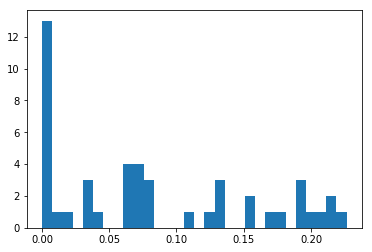

In [161]:
x=sorted(res, key=lambda a: -a[2])
plt.hist([a[2] for a in x], bins=30)

In [159]:
x

[(150, 150, 0.22645648325067527, False),
 (50, 700, 0.21361031463630756, False),
 (400, 250, 0.212705303797064, False),
 (350, 250, 0.20833800795873078, False),
 (50, 600, 0.19747772200978356, False),
 (600, 800, 0.1949346013943571, False),
 (600, 700, 0.1949346013943571, False),
 (700, 600, 0.1949346013943571, False),
 (350, 150, 0.17570257851578053, False),
 (50, 500, 0.1703623434038638, False),
 (500, 150, 0.1558047353401729, False),
 (150, 500, 0.1558047353401729, False),
 (400, 150, 0.13543315547998575, False),
 (150, 250, 0.1352350485715125, False),
 (50, 450, 0.13523206016795453, False),
 (50, 250, 0.12289955849620374, False),
 (50, 150, 0.11012578634387366, False),
 (150, 600, 0.07667219213886282, False),
 (600, 150, 0.07667219213886282, False),
 (500, 250, 0.07661629279120971, False),
 (400, 450, 0.06954910516288712, False),
 (600, 250, 0.06954910516288712, False),
 (350, 450, 0.06954910516288712, False),
 (350, 500, 0.06954910516288712, False),
 (150, 450, 0.06333316045979404